<center>
    
# Realizando Analsis de Datos
</center>

<center>

## Simulación y análisis ddatosto basados en pronósticos de series de tiempos en la empresa Cerámicas el Cinco.

</cener>


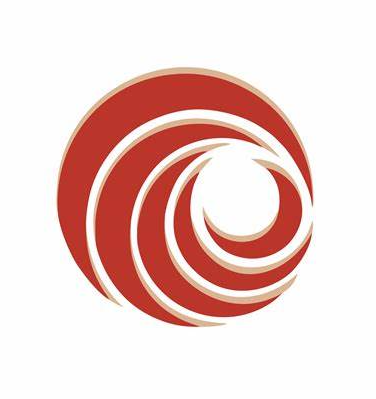

<center>

### Jessika Estefania Bello

### Janier Hersain Rosero

</center>

### Tabla de Contenido
### [Introduccion](#Introduccion)

1. [Importacion de Librerias](#Importacion-de-Librerias)
   
2. [Analisis Exploratorio](#Analisis-Exploratorio)
    ###### 2.1. [Analisis Exploratorio (Negocio)](#Analisis-Exploratorio-de-Datos-(Negocio))
    ###### 2.2. [Analisis Exploratorio (Estadistico)](#Analisis-Exploratorio-Estadistico)
    ###### 2.3. [Analisis Estadistico de Estacionalidad](#Analisis-Estadistico-de-Estacionalidad)
      ###### 2.3.1. [Prueba Regresion Lineal](#Prueba-Regresion-Lineal)
      ###### 2.3.2. [Prueba de estacionalidad Augmented Dickey-Fuller](#Prueba-de-estacionalidad-ADF-(Augmented-Dickey-Fuller))

3. [Determinacion de Anomalias](#Determinacion-de-Anomalias)
   ###### 3.1. [Parte 1. Anomalias en Serie Estacional Diaria](#Parte-1.-Anomalias-en-Serie-Estacional-Diaria)
   ###### 3.2. [Parte 2. Anomalias en Serie Estacional Semanal](#Parte-1.-Anomalias-en-Serie-Estacional-Semanal)

4. [Control de Estacionalidad](#Control-de-Estacionalidad)
   ###### 4.1. [Tecnica de Suavizado EWM](#Tecnica-de-Suavizado-EWM)
   ###### 4.1. [Tecnica de Logaritmica](#Tecnica-de-Logaritmica)

5. [Modelacion](#Modelacion)
   ###### 5.1 [Arquitectura de Modelo de Redes Neuronales](#Arquitectura-de-Modelo-de-Redes-Neuronales)
   ###### 5.1.1. [Modelo de Redes Neuronales LSTM](#Modelo-de-Redes-Neuronales-LSTM)
   ###### 5.1.2. [Modelo de Redes Neuronales RNN](#Modelo-de-Redes-Neuronales-RNN)
   
7. [Evaluacion de Modelos - LSTM vs RNN](#Evaluacion-de-Modelos---LSTM-vs-RNN)
    ###### 6.1. [Distribucion de Datos Reales vs Predecidos en Histograma](#Distribucion-de-Datos-Reales-vs-Predecidos-en-Histograma)
    ###### 6.2. [Distribucion de Datos Reales vs Predecidos en Dispersion](#Distribucion-de-Datos-Reales-vs-Predecidos-en-Dispersion)
    ###### 6.3. [Evaluacion de Metricas](#Evaluacion-de-Metricas)

### Introduccion
Cerámicas el Cinco es una empresa líder dedicada a la elaboración de materiales para construcción ubicada en el departamento de sucre. Uno de los productos estrella de la empresa es la elaboración de diferentes referencias de ladrillos, El siguiente componente relaciona la extracción de datos brutos y el analisis exploratorio de los datos con el finde determinar **anomalias**, situaicones de **estacionalidad** y el balance de ventas por poducto. 

Finalmente se haran los tratamientos necesarios para corregir anomalias y la estacionalidad que pueda llegarse a presentar, ademas de incluir una comparacion entre modelos de redes neuronas entre CNN y LSTM para realizar pronosticos de ventas en series temporales.

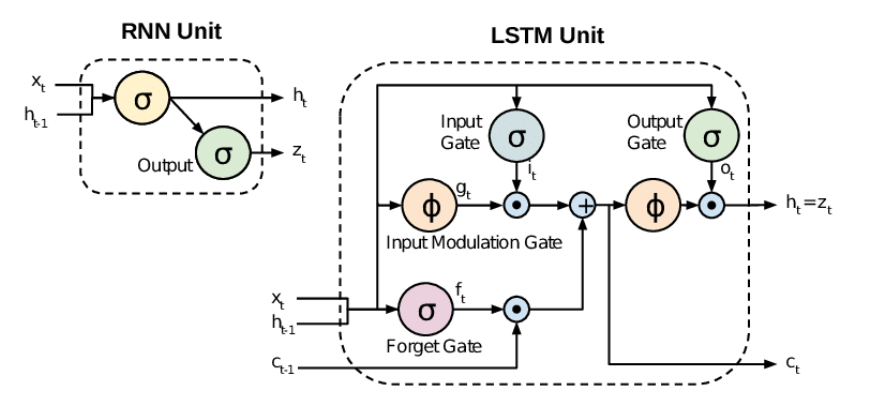

### Importacion de Librerias

In [1]:
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as smi
import statsmodels.api as sm
import ruptures as rpt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.linear_model import LinearRegression
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.optimizers import Adam
from keras_self_attention import SeqSelfAttention
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.layers import Dropout
import warnings

warnings.simplefilter('ignore')

### Analisis Exploratorio

In [2]:
df = pd.read_excel(r'C:/Users/PC/Desktop/ML/Data/bello.xlsx')
df.head(5)

,FECHA,REFERENCIA,UNIDADES VENDIDAS
0,2023-01-02,BL001 BLOQUE N° 4,2000
1,2023-01-02,BL001 BLOQUE N° 4,750
2,2023-01-02,BL001 BLOQUE N° 4,700
3,2023-01-02,BL001 BLOQUE N° 4,100
4,2023-01-02,BL001 BLOQUE N° 4,750


In [3]:
df['FECHA'] = pd.to_datetime(df['FECHA'])
df['AÑO_SEMANA'] = df['FECHA'].dt.strftime('%Y-%U')
df['AÑO_MES'] = df['FECHA'].dt.strftime('%Y-%M')
df['AÑO'] = df['FECHA'].dt.year

In [4]:
df.head(1)

,FECHA,REFERENCIA,UNIDADES VENDIDAS,AÑO_SEMANA,AÑO_MES,AÑO
0,2023-01-02,BL001 BLOQUE N° 4,2000,2023-01,2023-00,2023


In [5]:
df.isnull().sum()

FECHA                0
REFERENCIA           0
UNIDADES VENDIDAS    0
AÑO_SEMANA           0
AÑO_MES              0
AÑO                  0
dtype: int64

In [6]:
df = df.dropna()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22777 entries, 0 to 22776
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   FECHA              22777 non-null  datetime64[ns]
 1   REFERENCIA         22777 non-null  object        
 2   UNIDADES VENDIDAS  22777 non-null  int64         
 3   AÑO_SEMANA         22777 non-null  object        
 4   AÑO_MES            22777 non-null  object        
 5   AÑO                22777 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.0+ MB


In [8]:
df.describe()

,UNIDADES VENDIDAS,AÑO
count,22777.000000,22777.000000
mean,1269.973877,2020.283049
std,1493.939101,1.633587
min,0.000000,2018.000000
25%,300.000000,2019.000000
50%,900.000000,2020.000000
75%,2000.000000,2022.000000
max,20250.000000,2023.000000


In [9]:
df.median()

UNIDADES VENDIDAS     900.0
AÑO                  2020.0
dtype: float64

In [10]:
df.skew()

UNIDADES VENDIDAS    3.037351
AÑO                  0.150454
dtype: float64

In [11]:
df.kurt()

UNIDADES VENDIDAS    13.965587
AÑO                  -1.155958
dtype: float64

In [12]:
df.columns

Index(['FECHA', 'REFERENCIA', 'UNIDADES VENDIDAS', 'AÑO_SEMANA', 'AÑO_MES',
       'AÑO'],
      dtype='object')

In [13]:
df.shape

(22777, 6)

#### Analisis Exploratorio de Datos (Negocio)

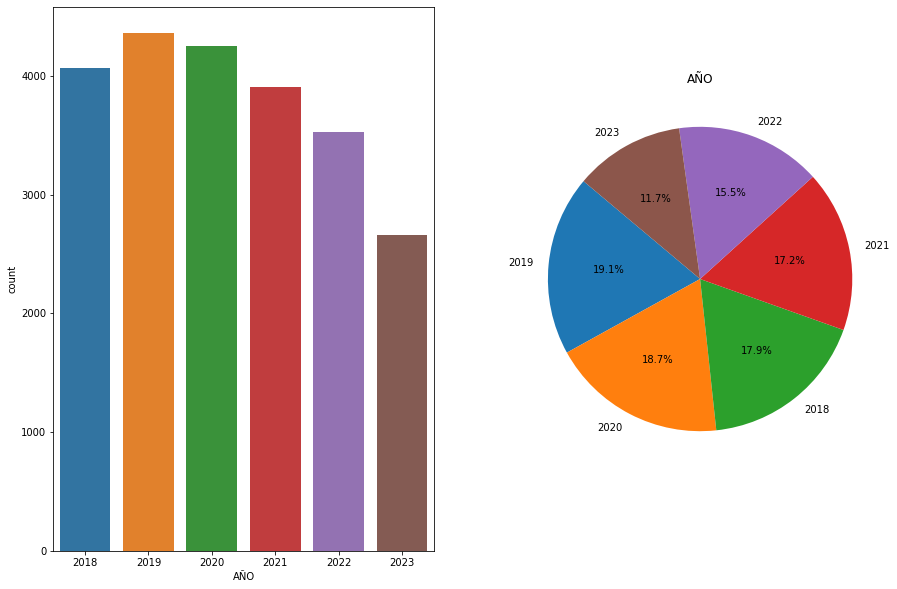

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

sns.countplot(data = df, x = 'AÑO', ax = ax[0])
ax[1].pie(df['AÑO'].value_counts(), labels=df['AÑO'].value_counts().index, autopct='%1.1f%%', startangle=140)
ax[1].set_title('AÑO')

plt.show()

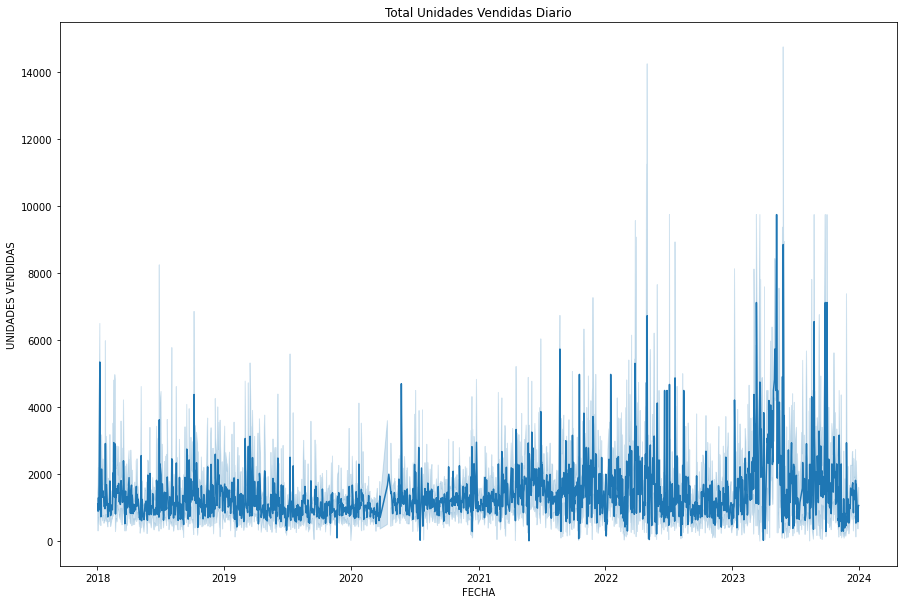

In [15]:
plt.figure(figsize=(15,10))
sns.lineplot(data = df, x='FECHA', y='UNIDADES VENDIDAS')
plt.title("Total Unidades Vendidas Diario")
plt.show()

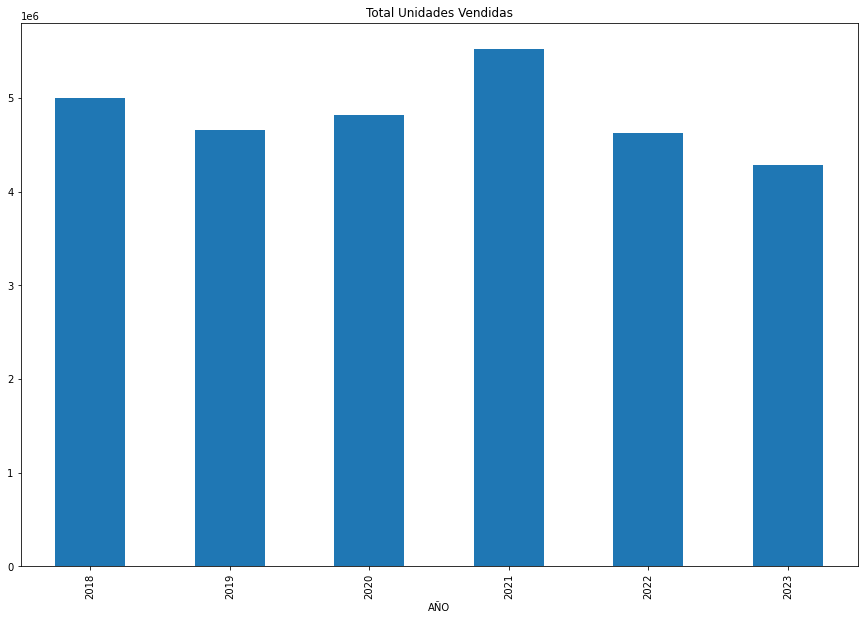

In [16]:
df.groupby('AÑO')['UNIDADES VENDIDAS'].sum().plot(kind = 'bar', figsize=(15,10), title ="Total Unidades Vendidas")
plt.show()

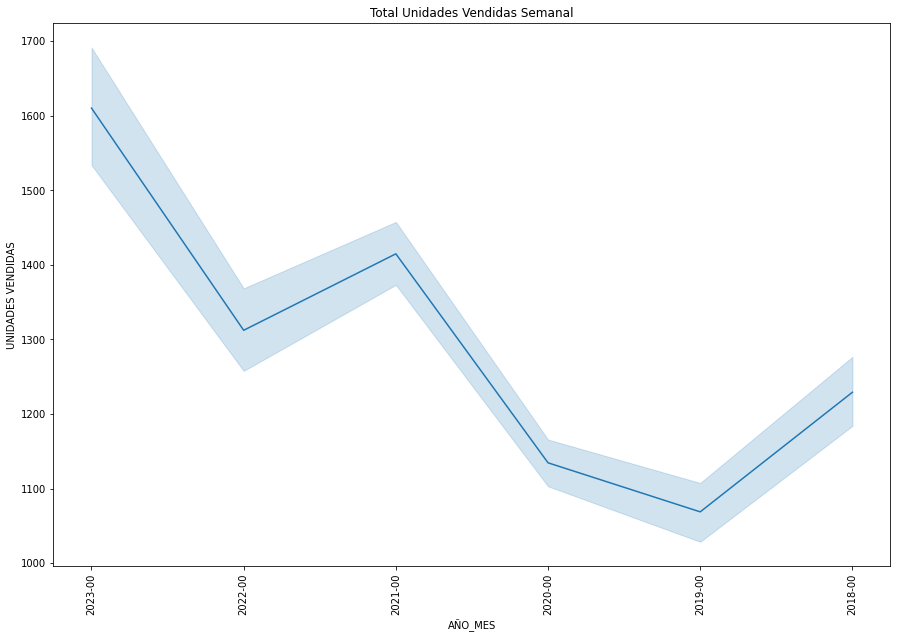

In [17]:
plt.figure(figsize=(15,10))
sns.lineplot(data = df, x='AÑO_MES', y='UNIDADES VENDIDAS')
plt.title("Total Unidades Vendidas Semanal")
plt.xticks(rotation=90)
plt.show()

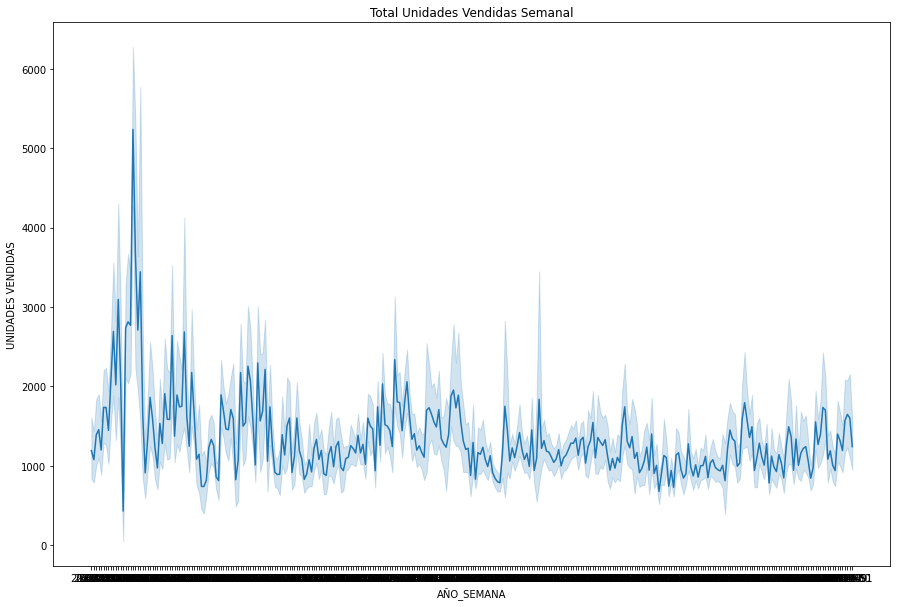

In [18]:
plt.figure(figsize=(15,10))
sns.lineplot(data = df, x='AÑO_SEMANA', y='UNIDADES VENDIDAS')
plt.title("Total Unidades Vendidas Semanal")
plt.show()

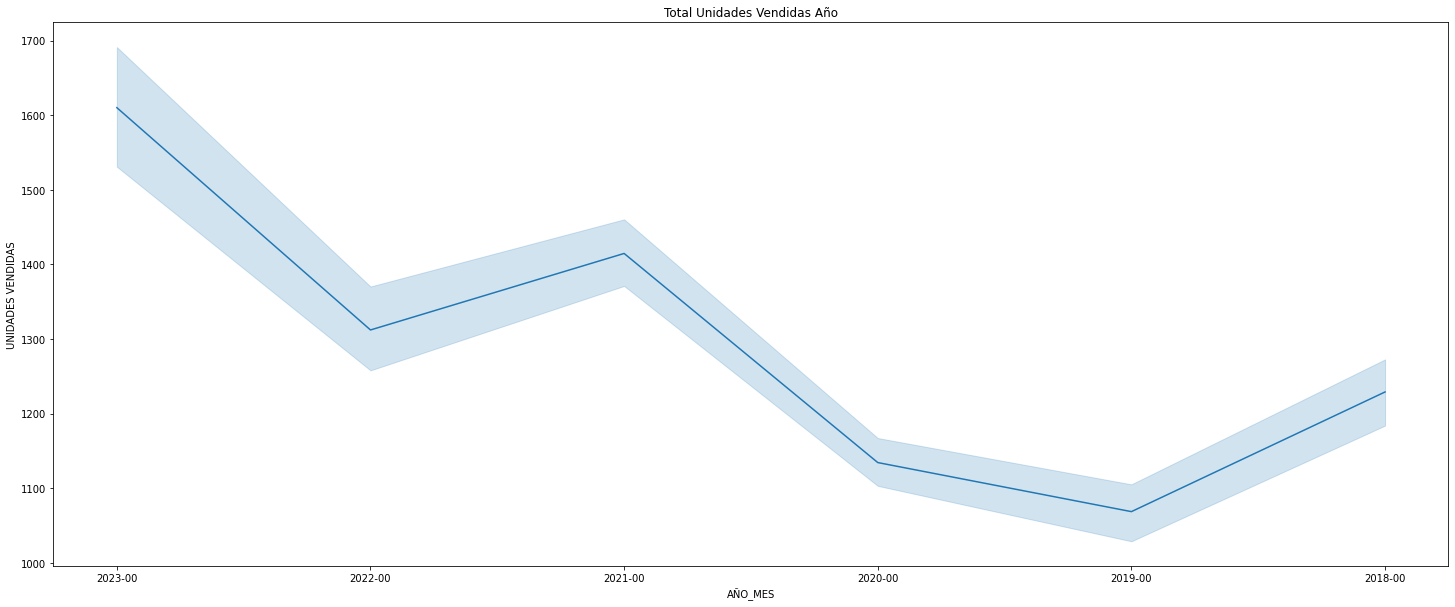

In [19]:
#dfg1_ = df.groupby('AÑO')['UNIDADES VENDIDAS'].sum()
plt.figure(figsize=(25,10))
sns.lineplot(data = df, x='AÑO_MES', y='UNIDADES VENDIDAS')
plt.title("Total Unidades Vendidas Año")
plt.show()

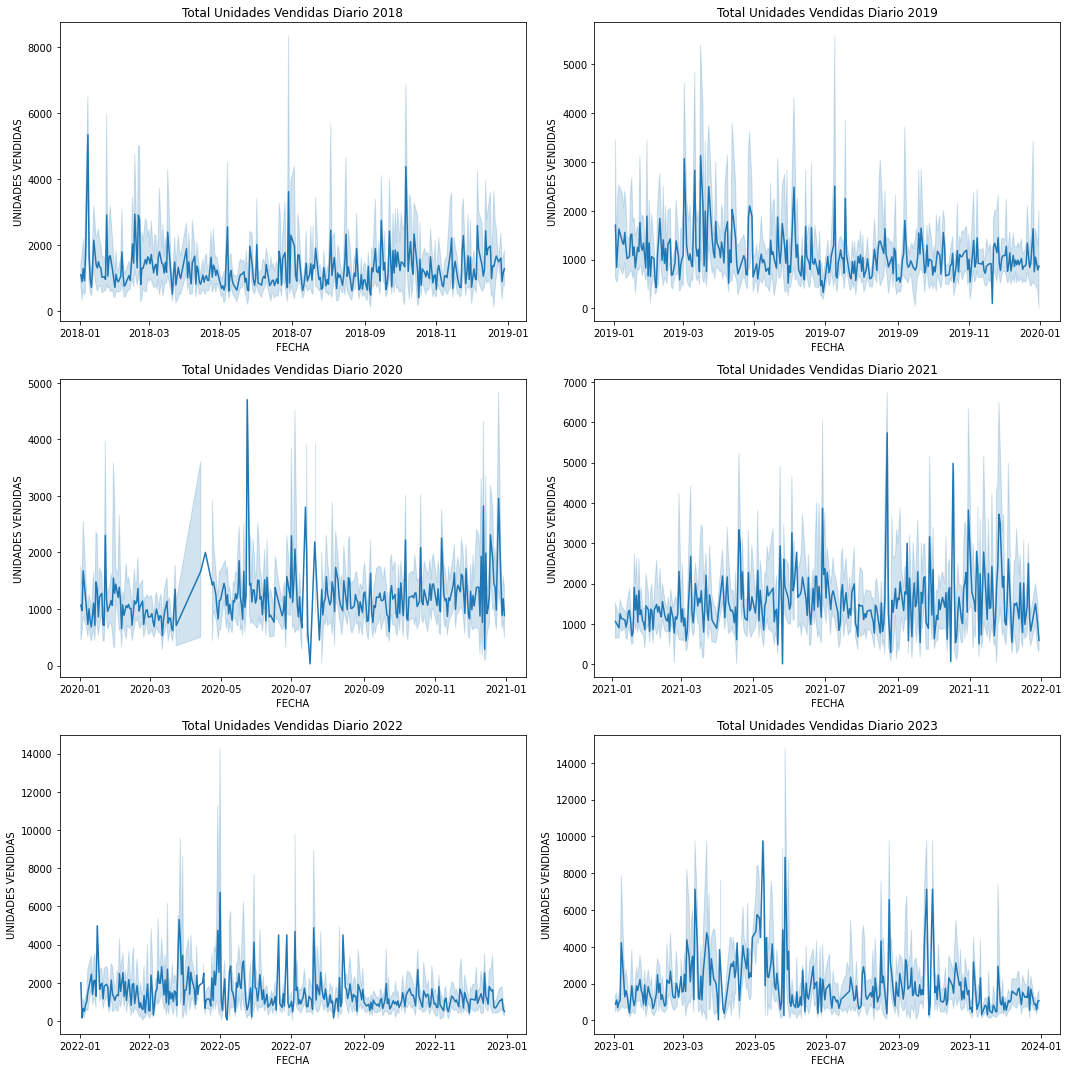

In [20]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

sns.lineplot(data=df[df['AÑO'] == 2018], x='FECHA', y='UNIDADES VENDIDAS', ax=ax[0, 0])
ax[0, 0].set_title("Total Unidades Vendidas Diario 2018")

sns.lineplot(data=df[df['AÑO'] == 2019], x='FECHA', y='UNIDADES VENDIDAS', ax=ax[0, 1])
ax[0, 1].set_title("Total Unidades Vendidas Diario 2019")

sns.lineplot(data=df[df['AÑO'] == 2020], x='FECHA', y='UNIDADES VENDIDAS', ax=ax[1, 0])
ax[1, 0].set_title("Total Unidades Vendidas Diario 2020")

sns.lineplot(data=df[df['AÑO'] == 2021], x='FECHA', y='UNIDADES VENDIDAS', ax=ax[1, 1])
ax[1, 1].set_title("Total Unidades Vendidas Diario 2021")

sns.lineplot(data=df[df['AÑO'] == 2022], x='FECHA', y='UNIDADES VENDIDAS', ax=ax[2, 0])
ax[2, 0].set_title("Total Unidades Vendidas Diario 2022")

sns.lineplot(data=df[df['AÑO'] == 2023], x='FECHA', y='UNIDADES VENDIDAS', ax=ax[2, 1])
ax[2, 1].set_title("Total Unidades Vendidas Diario 2023")

plt.tight_layout()  
plt.show()

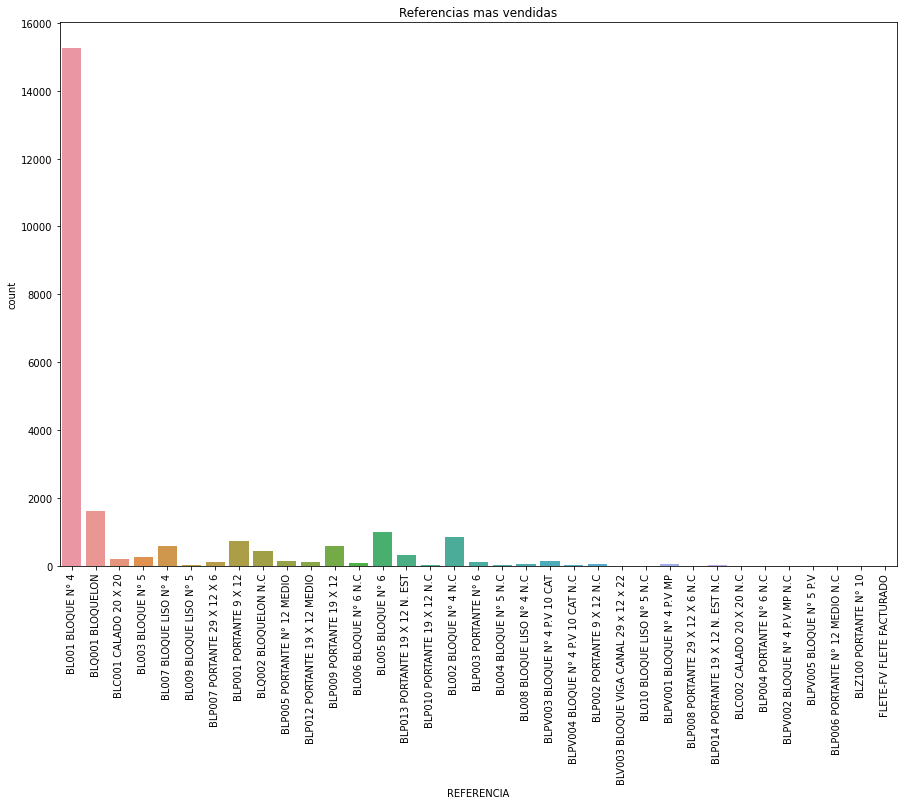

In [21]:
plt.figure(figsize=(15,10))
sns.countplot(data = df, x ='REFERENCIA')
plt.xticks(rotation=90)
plt.title("Referencias mas vendidas")
plt.show()

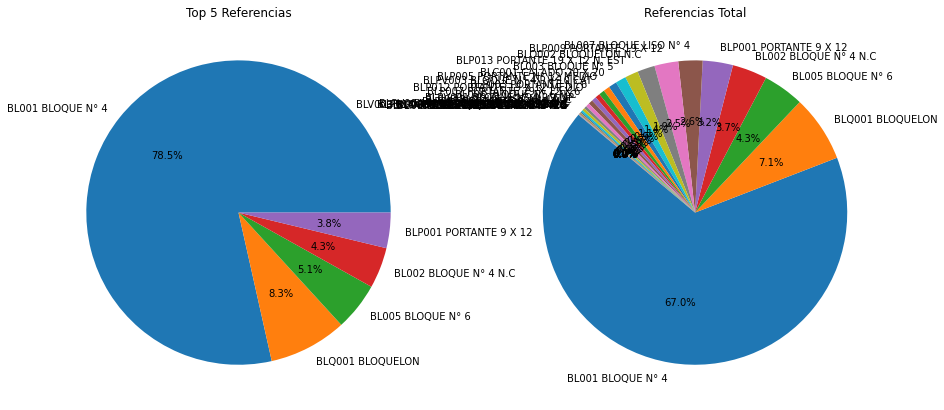

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

top_5_referencias = df['REFERENCIA'].value_counts().nlargest(5)
ax[0].pie(top_5_referencias, labels=top_5_referencias.index, autopct='%1.1f%%', startangle=0)
ax[0].set_title('Top 5 Referencias')

ax[1].pie(df['REFERENCIA'].value_counts(), labels=df['REFERENCIA'].value_counts().index, autopct='%1.1f%%', startangle=140)
ax[1].set_title('Referencias Total')

plt.show()

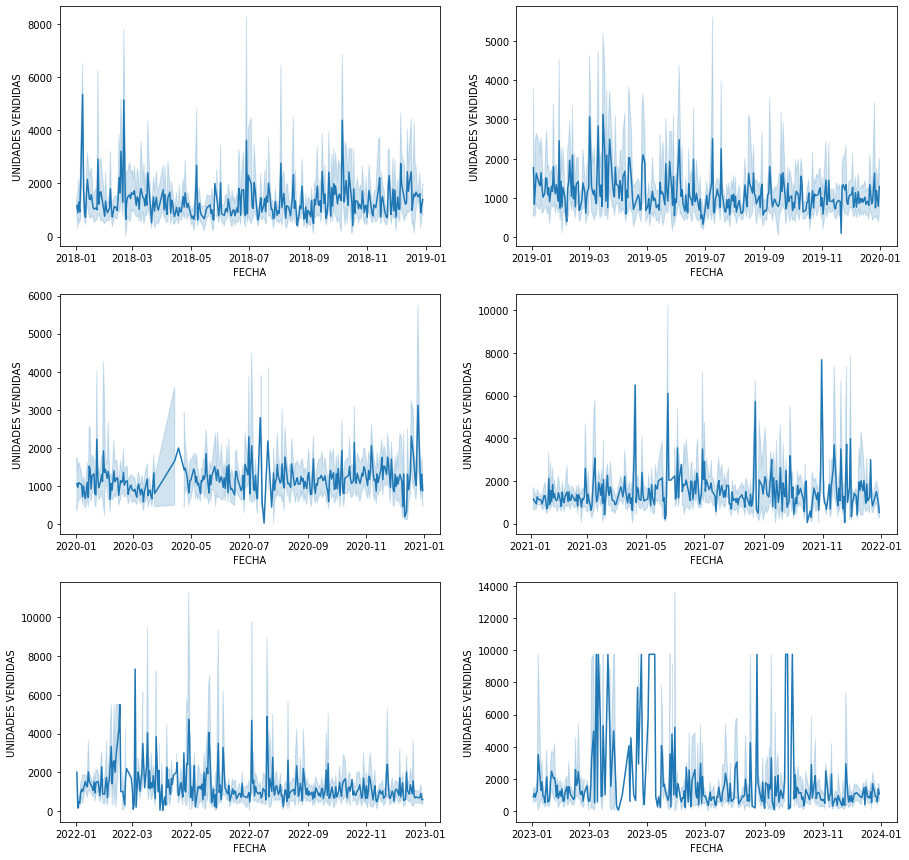

In [23]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
sns.lineplot(data=df[(df['AÑO'] == 2018) & df['REFERENCIA'].isin(top_5_referencias.index)], x='FECHA', y='UNIDADES VENDIDAS', ax=ax[0, 0])
sns.lineplot(data=df[(df['AÑO'] == 2019) & df['REFERENCIA'].isin(top_5_referencias.index)], x='FECHA', y='UNIDADES VENDIDAS', ax=ax[0, 1])
sns.lineplot(data=df[(df['AÑO'] == 2020) & df['REFERENCIA'].isin(top_5_referencias.index)], x='FECHA', y='UNIDADES VENDIDAS', ax=ax[1, 0])
sns.lineplot(data=df[(df['AÑO'] == 2021) & df['REFERENCIA'].isin(top_5_referencias.index)], x='FECHA', y='UNIDADES VENDIDAS', ax=ax[1, 1])
sns.lineplot(data=df[(df['AÑO'] == 2022) & df['REFERENCIA'].isin(top_5_referencias.index)], x='FECHA', y='UNIDADES VENDIDAS', ax=ax[2, 0])
sns.lineplot(data=df[(df['AÑO'] == 2023) & df['REFERENCIA'].isin(top_5_referencias.index)], x='FECHA', y='UNIDADES VENDIDAS', ax=ax[2, 1])
plt.show()

#### Analisis Exploratorio Estadistico

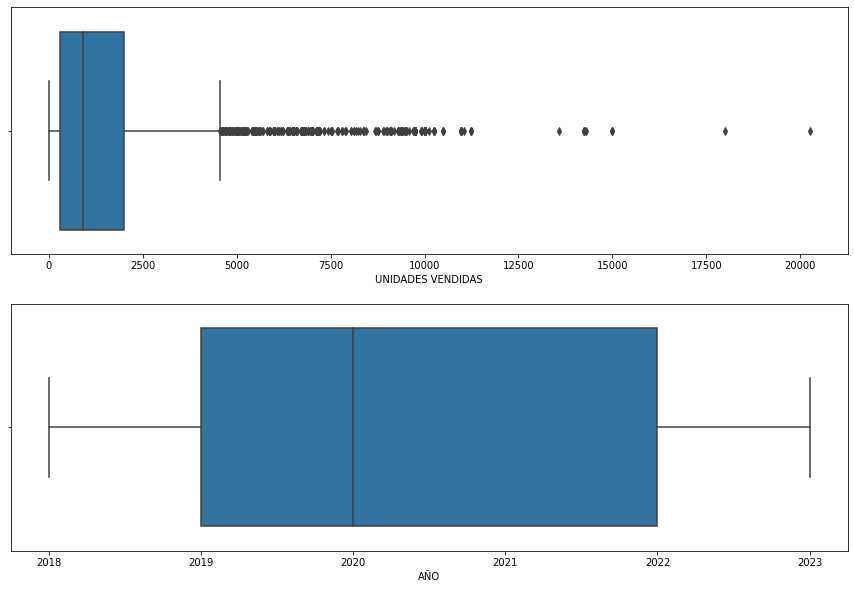

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

sns.boxplot(data = df, x = 'UNIDADES VENDIDAS', ax=ax[0])
sns.boxplot(data = df, x = 'AÑO', ax=ax[1])

plt.show()

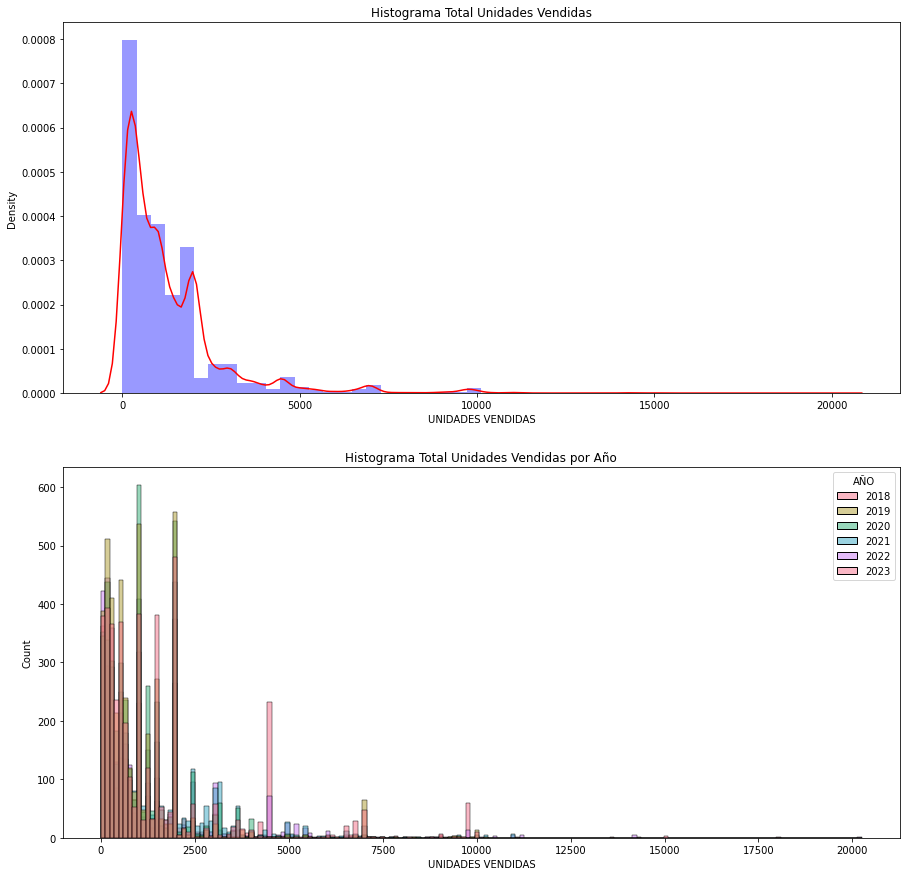

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(15, 15))

sns.distplot(df['UNIDADES VENDIDAS'],color='red', hist_kws={'color': 'blue'}, ax=ax[0])
sns.histplot(data=df, x='UNIDADES VENDIDAS', hue='AÑO', ax=ax[1], multiple='layer', palette='husl')

ax[0].set_title("Histograma Total Unidades Vendidas")
ax[1].set_title("Histograma Total Unidades Vendidas por Año")

plt.show()

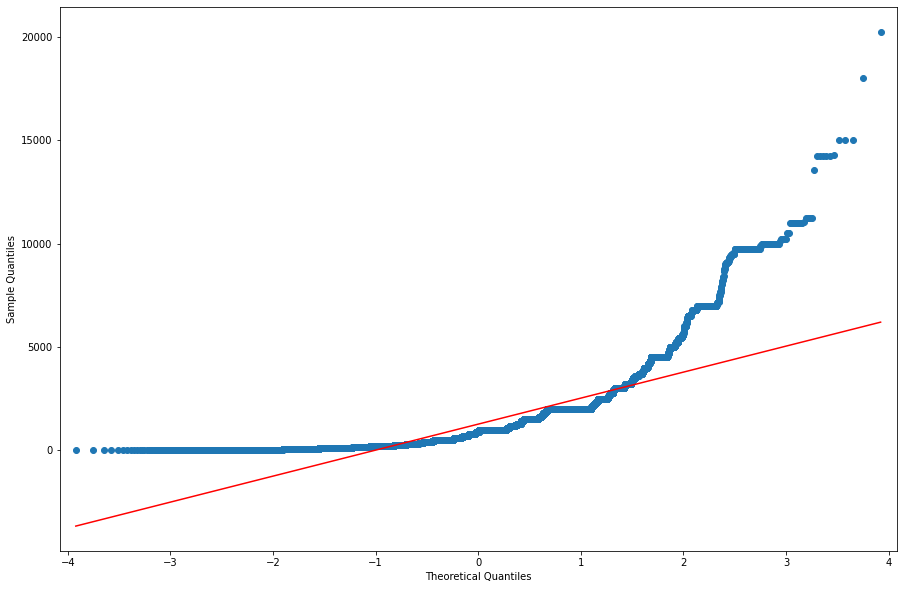

In [26]:
fig, ax = plt.subplots(figsize=(15, 10))
smi.qqplot(df['UNIDADES VENDIDAS'], line="r", ax=ax)
plt.show()

##### Analisis Estadistico de Estacionalidad

In [16]:
result = sm.tsa.seasonal_decompose(x=df['UNIDADES VENDIDAS'], model='additive', extrapolate_trend='freq', period=365) 

frame = {
    'Dates': df['FECHA'],
    'observed': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'residuals': result.resid
}
 
df_res = pd.DataFrame(frame).reset_index()

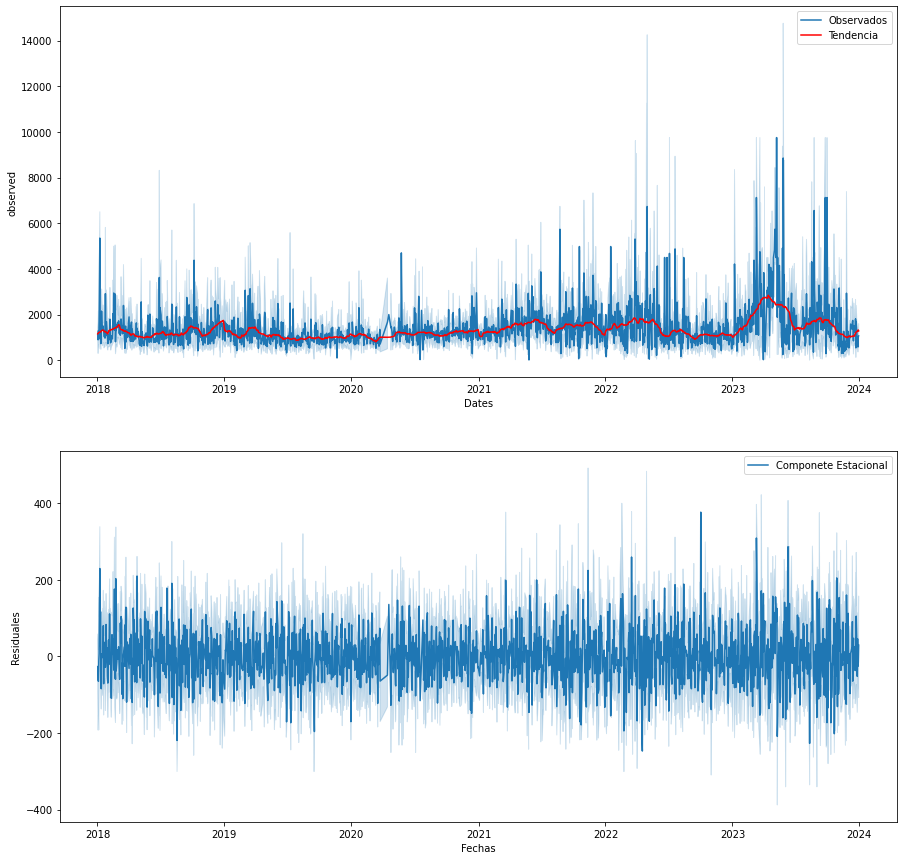

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(15, 15))

sns.lineplot(data=df_res, x='Dates', y='observed', label='Observados', ax = ax[0])
sns.lineplot(data=df_res, x='Dates', y='trend', label='Tendencia', color = 'red',ax = ax[0])

sns.lineplot(data=df_res, x='Dates', y='seasonal', label='Componete Estacional', ax = ax[1])
#sns.lineplot(data=df_res, x='Dates', y='residuals', label='Residuos',color = 'red',ax = ax[1])
ax[1].set_ylabel('Residuales')
ax[1].set_xlabel('Fechas')
plt.show()

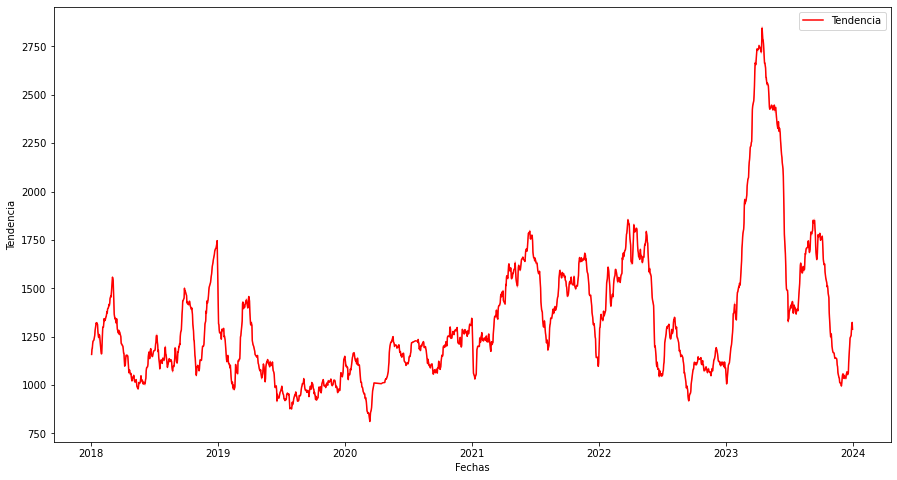

In [24]:
plt.figure(figsize=(15,8))
sns.lineplot(data=df_res, x='Dates', y='trend', label='Tendencia', color = 'red')
plt.ylabel('Tendencia')
plt.xlabel('Fechas')
plt.show()

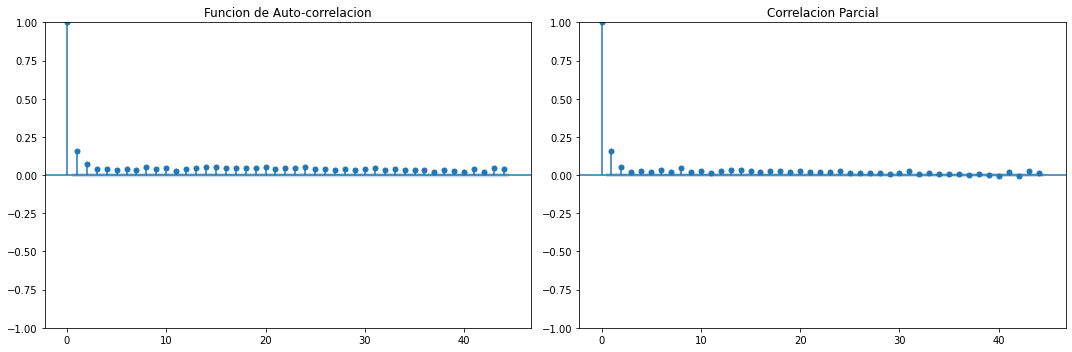

In [29]:
close_series = df['UNIDADES VENDIDAS']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(close_series, ax=axes[0])
axes[0].set_title('Funcion de Auto-correlacion')

plot_pacf(close_series, ax=axes[1])
axes[1].set_title('Correlacion Parcial')

plt.tight_layout()
plt.show()

##### Prueba Regresion Lineal

In [30]:
X = df[['FECHA']].values.reshape(-1, 1)
y = df['UNIDADES VENDIDAS']

modelo = LinearRegression()
modelo.fit(X, y)

pendiente = modelo.coef_[0]
intercepto = modelo.intercept_

print("Pendiente:", pendiente)
print("Intercepto:", intercepto)

Pendiente: 2.267547796015761e-15
Intercepto: -2363.2722698259695


##### Prueba de estacionalidad ADF (Augmented Dickey-Fuller)

In [31]:
result = adfuller(df['UNIDADES VENDIDAS'])

print('Estadística ADF:', result[0])
print('Valor p:', result[1])
print('Valores críticos:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

Estadística ADF: -14.705931210688593
Valor p: 2.89746756524861e-27
Valores críticos:
   1%: -3.4306377271733006
   5%: -2.861667166139514
   10%: -2.5668376869151417


Dado que el valor p es significativamente menor que cualquier nivel de significancia (1%, 5% o 10%), podemos rechazar la hipótesis nula. Por lo tanto, podemos concluir que la serie es estacionaria en términos de la prueba ADF.

### Determinacion de Anomalias

##### Parte 1. Anomalias en Serie Estacional Diaria

In [32]:
(df['UNIDADES VENDIDAS']).std()

1493.9391006683759

In [33]:
wind = 7
sigma = 2
df_Anomalias = df.groupby('FECHA')['UNIDADES VENDIDAS'].sum().reset_index()

In [34]:
df_Anomalias["Minimos"] = df_Anomalias['UNIDADES VENDIDAS'].rolling(window=wind).mean() - (sigma * 
                                                                                           df_Anomalias['UNIDADES VENDIDAS'].rolling(window=wind).std())

df_Anomalias["Maximos"] = df_Anomalias['UNIDADES VENDIDAS'].rolling(window=wind).mean() + (sigma * 
                                                                                           df_Anomalias['UNIDADES VENDIDAS'].rolling(window=wind).std())

df_Anomalias["Anomalias"] = df_Anomalias.apply(lambda row: row['UNIDADES VENDIDAS'] 
                                               if (row['UNIDADES VENDIDAS'] <= row["Minimos"] 
                                                   or row['UNIDADES VENDIDAS'] >= row["Maximos"]) 
                                               else 0, axis=1)

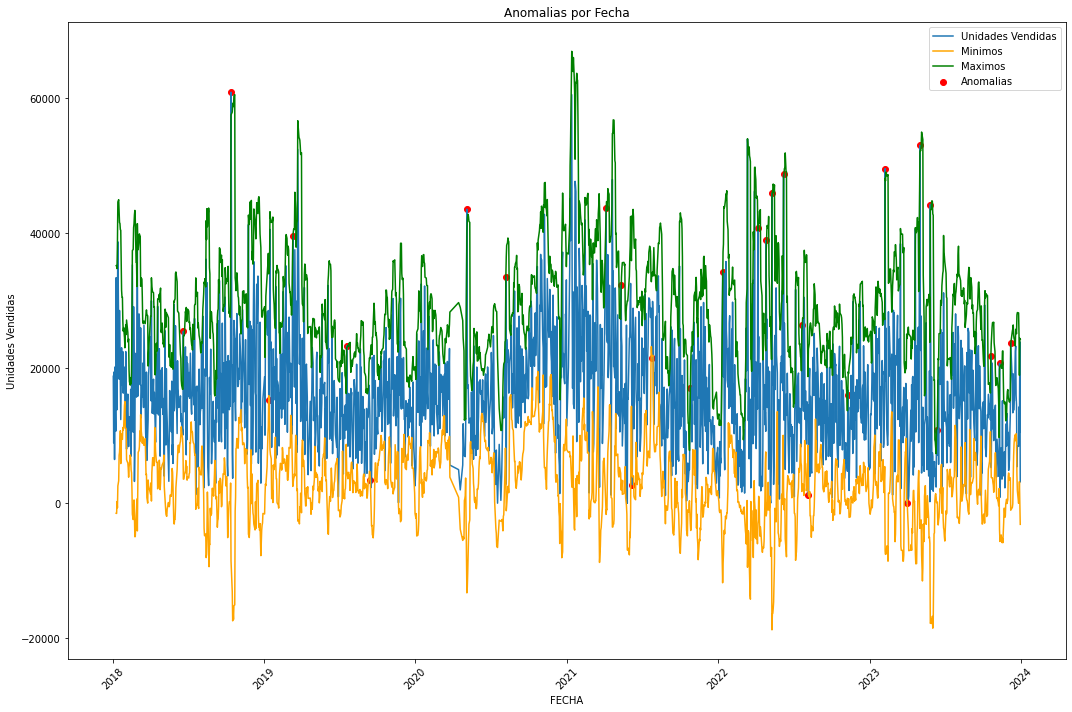

In [35]:
plt.figure(figsize=(15, 10))
plt.plot(df_Anomalias['FECHA'], df_Anomalias['UNIDADES VENDIDAS'], label='Unidades Vendidas')
plt.plot(df_Anomalias['FECHA'], df_Anomalias['Minimos'], label='Minimos', color='orange')
plt.plot(df_Anomalias['FECHA'], df_Anomalias['Maximos'], label='Maximos', color='green')
anomalias_reales = df_Anomalias[df_Anomalias['Anomalias'] > 0]
plt.scatter(anomalias_reales['FECHA'], anomalias_reales['Anomalias'], label='Anomalias', color='red', marker='o')
plt.title('Anomalias por Fecha')
plt.xlabel('FECHA')
plt.ylabel('Unidades Vendidas')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

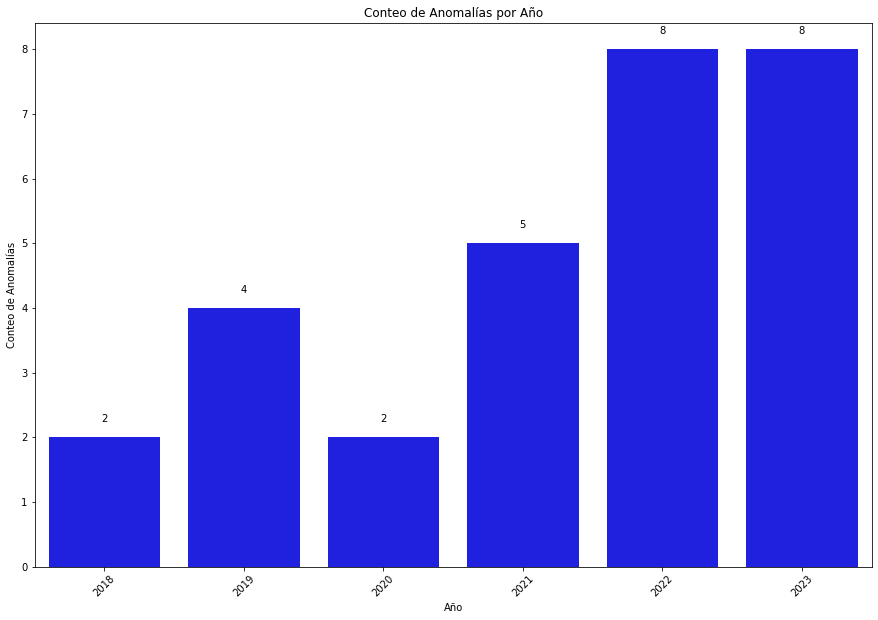

In [36]:
conteo_anomalias_por_año = df_Anomalias[df_Anomalias['Anomalias'] > 0].groupby(df_Anomalias['FECHA'].dt.year)['Anomalias'].count()

plt.figure(figsize=(15, 10))
sns.barplot(x=conteo_anomalias_por_año.index, y=conteo_anomalias_por_año.values, color='blue')

for i, valor in enumerate(conteo_anomalias_por_año.values):
    plt.text(i, valor + 0.2, str(valor), ha='center', va='bottom')

plt.title('Conteo de Anomalías por Año')
plt.xlabel('Año')
plt.ylabel('Conteo de Anomalías')
plt.xticks(rotation=45)
plt.show()

##### Parte 2. Anomalias en Serie Estacional Semanal
Debido a que en la serie temporal todos los dias no se generan ventas se toma la desicion de hacer una agrupacion por semana para realizar un mejor control sobre las anomalias, sin afectar a la toma de desiones del negocio ni incurriendo en tomar un intervalo de tiempo grande poco util para la empresa.

In [37]:
wind = 7
sigma = 2
df_Anomalias_semana = df.groupby('AÑO_SEMANA')['UNIDADES VENDIDAS'].sum().reset_index()

In [38]:
df_Anomalias_semana["Minimos"] = df_Anomalias_semana['UNIDADES VENDIDAS'].rolling(window=wind).mean() - (sigma * 
                                                                                           df_Anomalias_semana['UNIDADES VENDIDAS'].rolling(window=wind).std())

df_Anomalias_semana["Maximos"] = df_Anomalias_semana['UNIDADES VENDIDAS'].rolling(window=wind).mean() + (sigma * 
                                                                                           df_Anomalias_semana['UNIDADES VENDIDAS'].rolling(window=wind).std())

df_Anomalias_semana["Anomalias"] = df_Anomalias_semana.apply(lambda row: row['UNIDADES VENDIDAS'] 
                                               if (row['UNIDADES VENDIDAS'] <= row["Minimos"] 
                                                   or row['UNIDADES VENDIDAS'] >= row["Maximos"]) 
                                               else 0, axis=1)

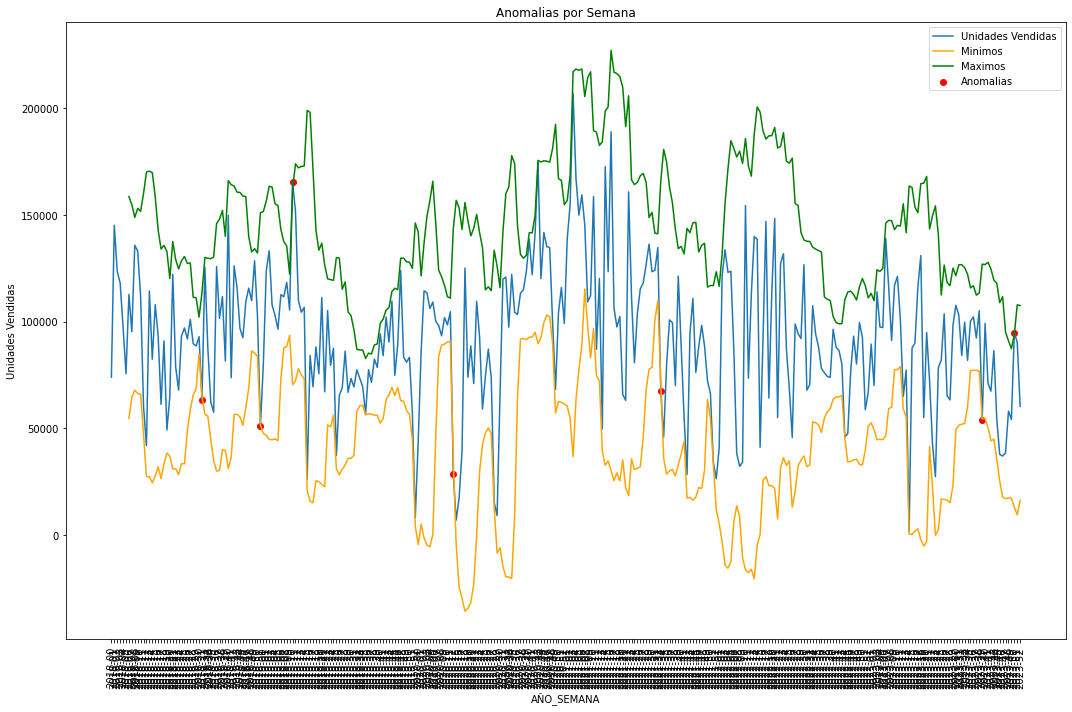

In [39]:
plt.figure(figsize=(15, 10))
plt.plot(df_Anomalias_semana['AÑO_SEMANA'], df_Anomalias_semana['UNIDADES VENDIDAS'], label='Unidades Vendidas')
plt.plot(df_Anomalias_semana['AÑO_SEMANA'], df_Anomalias_semana['Minimos'], label='Minimos', color='orange')
plt.plot(df_Anomalias_semana['AÑO_SEMANA'], df_Anomalias_semana['Maximos'], label='Maximos', color='green')
anomalias_reales_sem = df_Anomalias_semana[df_Anomalias_semana['Anomalias'] > 0]
plt.scatter(anomalias_reales_sem['AÑO_SEMANA'], anomalias_reales_sem['Anomalias'], label='Anomalias', color='red', marker='o')
plt.title('Anomalias por Semana')
plt.xlabel('AÑO_SEMANA')
plt.ylabel('Unidades Vendidas')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

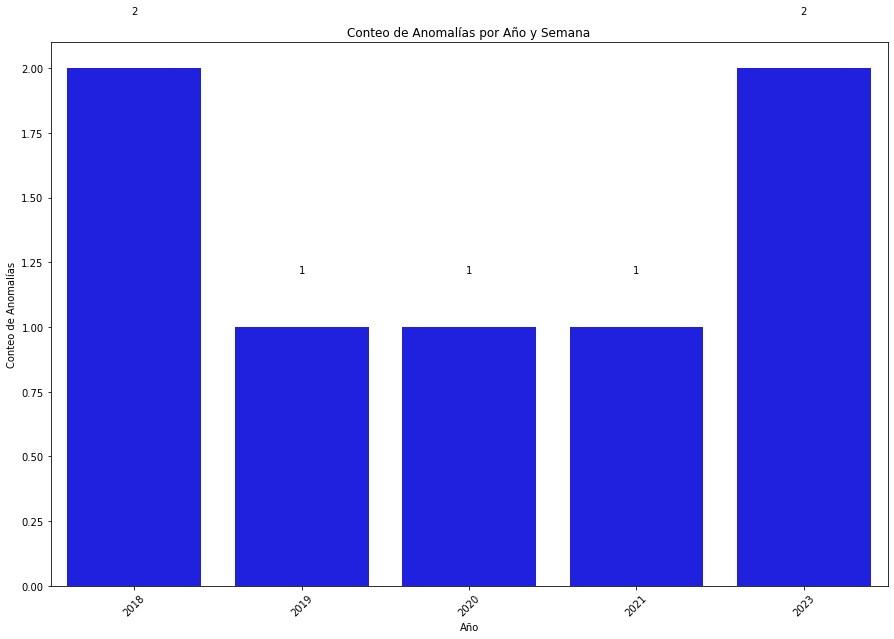

In [41]:
df_Anomalias_semana['AÑOS']=df_Anomalias_semana['AÑO_SEMANA'].apply(lambda x: int(x.split('-')[0]))
conteo_anomalias_sem = df_Anomalias_semana[df_Anomalias_semana['Anomalias'] > 0].groupby(df_Anomalias_semana['AÑOS'])['Anomalias'].count()

plt.figure(figsize=(15, 10))
sns.barplot(x=conteo_anomalias_sem.index, y=conteo_anomalias_sem.values, color='blue')

for i, valor in enumerate(conteo_anomalias_sem.values):
    plt.text(i, valor + 0.2, str(valor), ha='center', va='bottom')

plt.title('Conteo de Anomalías por Año y Semana')
plt.xlabel('Año')
plt.ylabel('Conteo de Anomalías')
plt.xticks(rotation=45)
plt.show()

#### Control de Estacionalidad
Debido a que en el control de anomalias anterior el mejor resultado fue la agrupacion por semana, utilizaremos este mismo conjunto de datos para suavizar la estacionalidad y controlar la distribucion de ventas.

In [42]:
df_corregido = df.groupby('AÑO_SEMANA')['UNIDADES VENDIDAS'].sum().reset_index()

##### Tecnica de Suavizado EWM

In [43]:
suavizado_ewm = df_corregido['UNIDADES VENDIDAS'].ewm(alpha=0.1).mean()

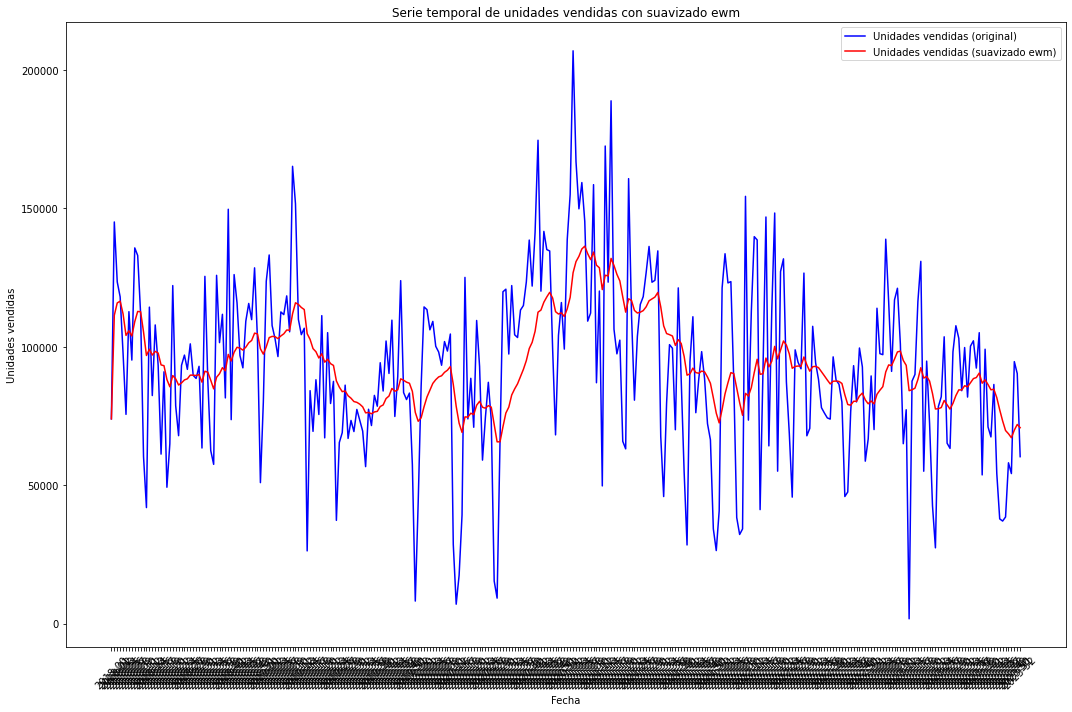

In [44]:
plt.figure(figsize=(15, 10))
plt.plot(df_corregido['AÑO_SEMANA'], df_corregido['UNIDADES VENDIDAS'], label='Unidades vendidas (original)', color='blue')
plt.plot(df_corregido['AÑO_SEMANA'], suavizado_ewm, label='Unidades vendidas (suavizado ewm)', color='red')
plt.xlabel('Fecha')
plt.ylabel('Unidades vendidas')
plt.title('Serie temporal de unidades vendidas con suavizado ewm')
plt.legend()
plt.grid(False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Tecnica de Logaritmica

In [45]:
log_unidades_vendidas = np.log(df_corregido['UNIDADES VENDIDAS'])

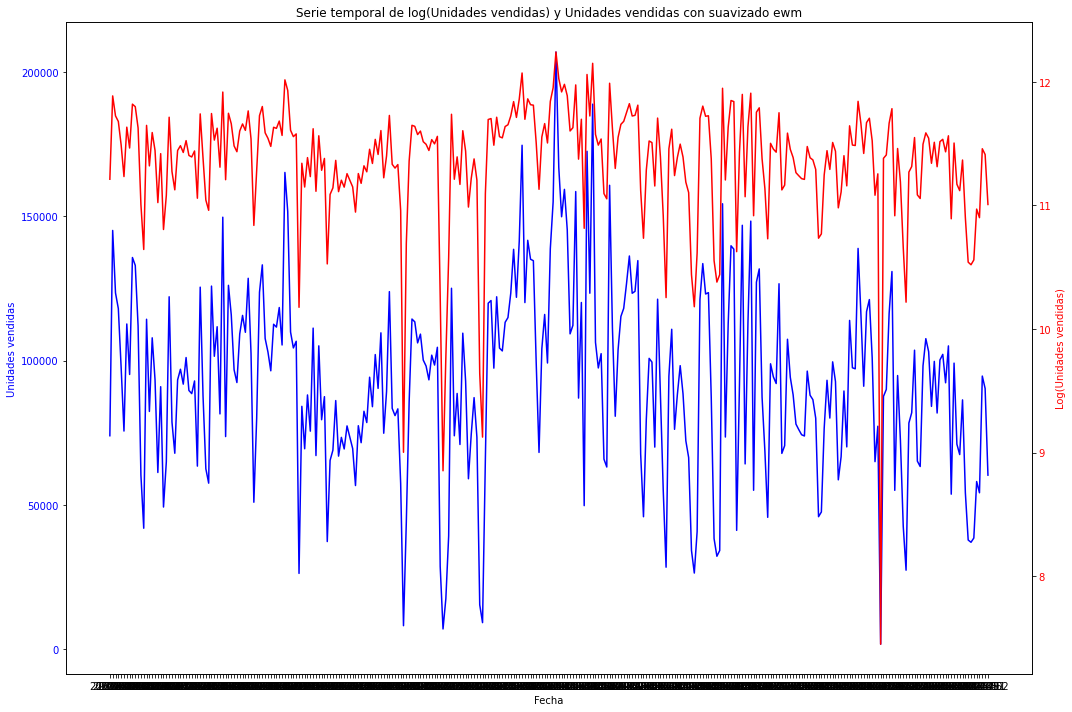

In [46]:
fig, ax1 = plt.subplots(figsize=(15, 10))

ax1.plot(df_corregido['AÑO_SEMANA'], df_corregido['UNIDADES VENDIDAS'], label='Unidades vendidas (original)', color='blue')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Unidades vendidas', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(df_corregido['AÑO_SEMANA'], log_unidades_vendidas, label='Unidades vendidas (logaritmo natural)', color='red')
ax2.set_ylabel('Log(Unidades vendidas)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Serie temporal de log(Unidades vendidas) y Unidades vendidas con suavizado ewm')
plt.grid(False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Modelacion

Segun los resultados anteriores, la tecnica de suavizado para logarismo presenta una distribucion con anomalias mas pronunciadas, sin embargo la tecnica de suavizado EWM, en su distribucion las anomalias se homogenisan debido a que utiliza la media de los valores con un factor alpha del 10%. Por lo tanto para la modelacion se emplearan los datos obtenidos en la tecnica EWM.

In [47]:
df_corregido['Datos_Suavizados'] = suavizado_ewm

In [48]:
df_corregido.isnull().sum()

AÑO_SEMANA           0
UNIDADES VENDIDAS    0
Datos_Suavizados     0
dtype: int64

In [49]:
df_modelo = df_corregido['Datos_Suavizados'].values.reshape(-1, 1)

In [50]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_modelo)

#### Arquitectura de Modelo de Redes Neuronales

In [51]:
def create_sequences(scaled_data, seq_length):
    sequences, labels = [], []
    for i in range(len(scaled_data) - seq_length):
        seq = scaled_data[i:i + seq_length, 0]  
        label = scaled_data[i + seq_length, 0]  
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [52]:
seq_length = 1
n_samples = len(scaled_data)
sequences, labels = create_sequences(scaled_data, seq_length)
split = int(0.5 * len(sequences))
X_train, y_train = sequences[:split], labels[:split]
X_test, y_test = sequences[split:], labels[split:]

##### Modelo de Redes Neuronales LSTM

In [53]:
model_lstm = Sequential()
model_lstm.add(LSTM(100, activation='relu', input_shape=(seq_length, 1), return_sequences=True))
model_lstm.add(LSTM(50, activation='relu'))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

In [54]:
model_lstm.fit(X_train, y_train, epochs=100, batch_size=1, validation_data=(X_test, y_test))
predictions_lstm = model_lstm.predict(X_test)

Epoch 1/100
155/155 [==============================] - 7s 15ms/step - loss: 0.1658 - val_loss: 0.2008
Epoch 2/100
155/155 [==============================] - 1s 9ms/step - loss: 0.1408 - val_loss: 0.1688
Epoch 3/100
155/155 [==============================] - 1s 9ms/step - loss: 0.1102 - val_loss: 0.1293
Epoch 4/100
155/155 [==============================] - 1s 9ms/step - loss: 0.0753 - val_loss: 0.0854
Epoch 5/100
155/155 [==============================] - 1s 9ms/step - loss: 0.0435 - val_loss: 0.0499
Epoch 6/100
155/155 [==============================] - 1s 9ms/step - loss: 0.0246 - val_loss: 0.0316
Epoch 7/100
155/155 [==============================] - 1s 9ms/step - loss: 0.0181 - val_loss: 0.0261
Epoch 8/100
155/155 [==============================] - 1s 9ms/step - loss: 0.0164 - val_loss: 0.0236
Epoch 9/100
155/155 [==============================] - 1s 9ms/step - loss: 0.0155 - val_loss: 0.0214
Epoch 10/100
155/155 [==============================] - 1s 9ms/step - loss: 0.0148 - val_l

In [55]:
dates_test = df_corregido['AÑO_SEMANA'].iloc[split + seq_length:]
df_plot_lstm = pd.DataFrame({'Dates_': dates_test,'Real': y_test.flatten(), 'Predict': predictions_lstm.flatten()})

##### Modelo de Redes Neuronales RNN

In [56]:
model_RNN = Sequential()
model_RNN.add(SimpleRNN(100, activation='relu', input_shape=(seq_length, 1), return_sequences=True))
model_RNN.add(SimpleRNN(50, activation='relu'))
model_RNN.add(Dense(1))
model_RNN.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

In [57]:
model_RNN.fit(X_train, y_train, epochs=100, batch_size=1, validation_data=(X_test, y_test))
predictions_scaled_RNN = model_RNN.predict(X_test)

Epoch 1/100
155/155 [==============================] - 6s 13ms/step - loss: 0.1408 - val_loss: 0.0846
Epoch 2/100
155/155 [==============================] - 1s 9ms/step - loss: 0.0290 - val_loss: 0.0204
Epoch 3/100
155/155 [==============================] - 1s 8ms/step - loss: 0.0094 - val_loss: 0.0115
Epoch 4/100
155/155 [==============================] - 1s 9ms/step - loss: 0.0074 - val_loss: 0.0095
Epoch 5/100
155/155 [==============================] - 1s 9ms/step - loss: 0.0065 - val_loss: 0.0079
Epoch 6/100
155/155 [==============================] - 1s 8ms/step - loss: 0.0058 - val_loss: 0.0067
Epoch 7/100
155/155 [==============================] - 1s 9ms/step - loss: 0.0052 - val_loss: 0.0056
Epoch 8/100
155/155 [==============================] - 1s 8ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 9/100
155/155 [==============================] - 1s 8ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 10/100
155/155 [==============================] - 1s 9ms/step - loss: 0.0041 - val_l

In [58]:
df_plot_RNN = pd.DataFrame({'Dates_': dates_test,'Real': y_test.flatten(), 'Predict': predictions_scaled_RNN.flatten()})

#### Evaluacion de Modelos - LSTM vs RNN

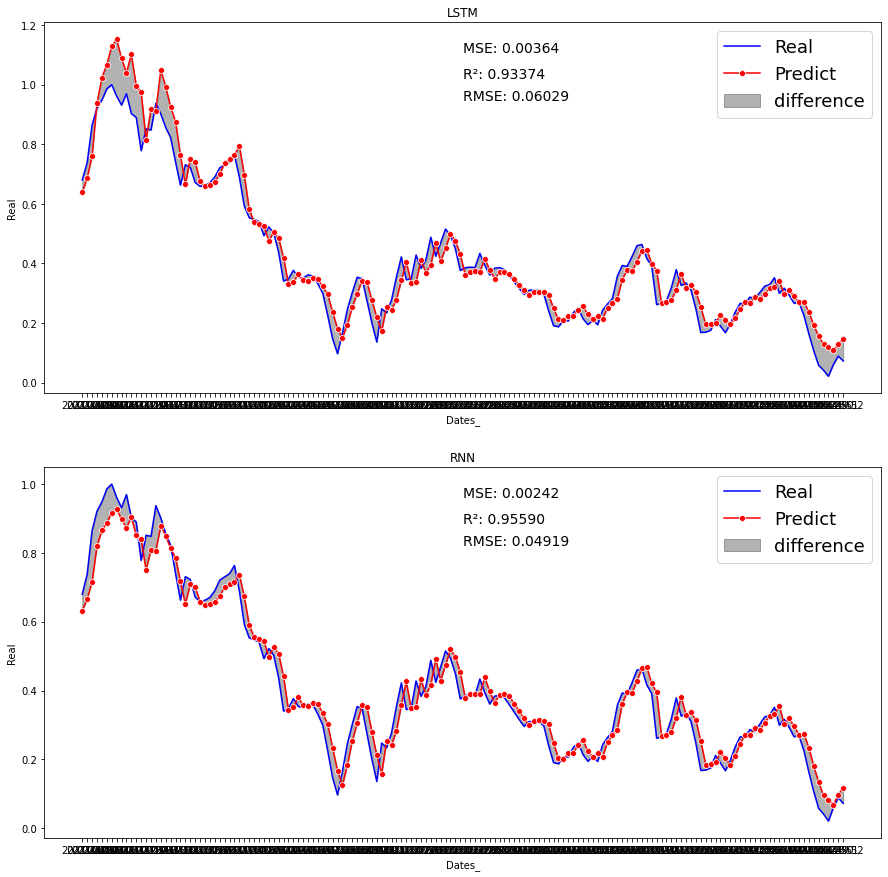

In [59]:
mse_lstm = mean_squared_error(df_plot_lstm['Real'], df_plot_lstm['Predict'])
mse_rnn = mean_squared_error(df_plot_RNN['Real'], df_plot_RNN['Predict'])

r2_lstm = r2_score(df_plot_lstm['Real'], df_plot_lstm['Predict'])
r2_rnn = r2_score(df_plot_RNN['Real'], df_plot_RNN['Predict'])

rmse_lstm = mean_squared_error(df_plot_lstm['Real'], df_plot_lstm['Predict'], squared=False)
rmse_rnn = mean_squared_error(df_plot_RNN['Real'], df_plot_RNN['Predict'], squared=False)


fig, ax = plt.subplots(2, 1, figsize=(15, 15))

sns.lineplot(x='Dates_', y='Real', data=df_plot_lstm, label='Real', color='blue', ax = ax[0])
sns.lineplot(x='Dates_', y='Predict', data=df_plot_lstm, label='Predict', color='red', ax = ax[0], marker="o",)
ax[0].fill_between(df_plot_lstm['Dates_'], df_plot_lstm['Real'], df_plot_lstm['Predict'], color='black', alpha=0.3, label='difference')

sns.lineplot(x='Dates_', y='Real', data=df_plot_RNN, label='Real', color='blue', ax = ax[1])
sns.lineplot(x='Dates_', y='Predict', data=df_plot_RNN, label='Predict', color='red', ax = ax[1], marker="o")
ax[1].fill_between(df_plot_RNN['Dates_'], df_plot_RNN['Real'], df_plot_RNN['Predict'], color='black', alpha=0.3, label='difference')

ax[0].text(0.5, 0.85, f'R²: {r2_lstm:.5f}', fontsize=14, color='black', transform=ax[0].transAxes)
ax[0].text(0.5, 0.92, f'MSE: {mse_lstm:.5f}', fontsize=14, color='black', transform=ax[0].transAxes)
ax[0].text(0.5, 0.79, f'RMSE: {rmse_lstm:.5f}', fontsize=14, color='black', transform=ax[0].transAxes)

ax[1].text(0.5, 0.85, f'R²: {r2_rnn:.5f}', fontsize=14, color='black', transform=ax[1].transAxes)
ax[1].text(0.5, 0.92, f'MSE: {mse_rnn:.5f}', fontsize=14, color='black', transform=ax[1].transAxes)
ax[1].text(0.5, 0.79, f'RMSE: {rmse_rnn:.5f}', fontsize=14, color='black', transform=ax[1].transAxes)


ax[0].set_title('LSTM')
ax[1].set_title('RNN')

ax[0].legend(fontsize=18)
ax[1].legend(fontsize=18)

plt.show()

In [67]:
df_plot_lstm_total = pd.DataFrame({'Dates_': dates_test, 'Real': y_test.flatten(), 'Predict': predictions_lstm.flatten()})
df_plot_RNN_total = pd.DataFrame({'Dates_': dates_test, 'Real': y_test.flatten(), 'Predict': predictions_scaled_RNN.flatten()})

df_plot_lstm_total['Predict_scaler'] = scaler.inverse_transform(df_plot_lstm_total['Predict'].values.reshape(-1, 1))
df_plot_RNN_total['Predict_scaler'] = scaler.inverse_transform(df_plot_RNN_total['Predict'].values.reshape(-1, 1))

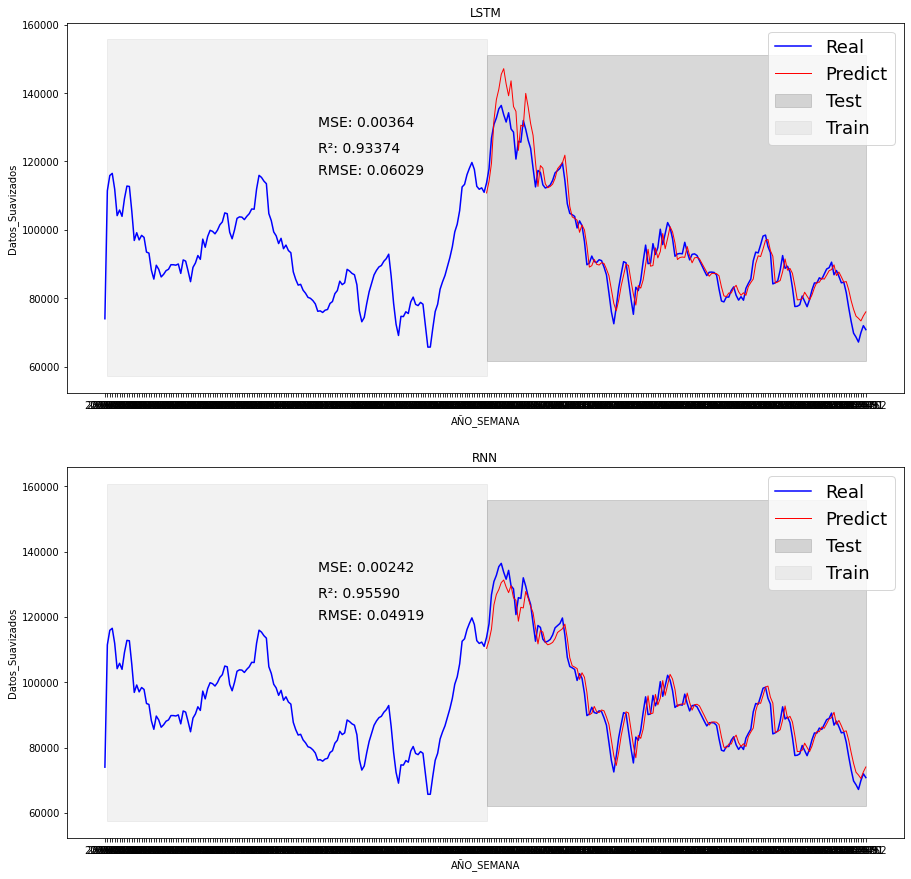

In [72]:
mse_lstm = mean_squared_error(df_plot_lstm['Real'], df_plot_lstm['Predict'])
mse_rnn = mean_squared_error(df_plot_RNN['Real'], df_plot_RNN['Predict'])

r2_lstm = r2_score(df_plot_lstm['Real'], df_plot_lstm['Predict'])
r2_rnn = r2_score(df_plot_RNN['Real'], df_plot_RNN['Predict'])

rmse_lstm = mean_squared_error(df_plot_lstm['Real'], df_plot_lstm['Predict'], squared=False)
rmse_rnn = mean_squared_error(df_plot_RNN['Real'], df_plot_RNN['Predict'], squared=False)


fig, ax = plt.subplots(2, 1, figsize=(15, 15))

sns.lineplot(x='AÑO_SEMANA', y='Datos_Suavizados', 
             data=df_corregido, label='Real', color='blue', ax = ax[0])

sns.lineplot(x='Dates_', y='Predict_scaler', 
             data=df_plot_lstm_total, label='Predict', color='red', ax = ax[0],linewidth=1)

sns.lineplot(x='AÑO_SEMANA', y='Datos_Suavizados', 
             data=df_corregido, label='Real', color='blue', ax = ax[1])

sns.lineplot(x='Dates_', y='Predict_scaler', 
             data=df_plot_RNN_total, label='Predict', color='red', ax = ax[1],linewidth=1)


ax[0].fill_betweenx(y=[ax[0].get_ylim()[0], ax[0].get_ylim()[1]], x1='2021-01', x2='2023-52', color='gray', alpha=0.3, label='Test')
ax[1].fill_betweenx(y=[ax[1].get_ylim()[0], ax[0].get_ylim()[1]], x1='2021-01', x2='2023-52', color='gray', alpha=0.3, label='Test')

ax[0].fill_betweenx(y=[ax[0].get_ylim()[0], ax[0].get_ylim()[1]], x1='2018-01', x2='2021-01', color='gray', alpha=0.1, label='Train')
ax[1].fill_betweenx(y=[ax[1].get_ylim()[0], ax[0].get_ylim()[1]], x1='2018-01', x2='2021-01', color='gray', alpha=0.1, label='Train')

ax[0].text(0.3, 0.65, f'R²: {r2_lstm:.5f}', fontsize=14, color='black', transform=ax[0].transAxes)
ax[0].text(0.3, 0.72, f'MSE: {mse_lstm:.5f}', fontsize=14, color='black', transform=ax[0].transAxes)
ax[0].text(0.3, 0.59, f'RMSE: {rmse_lstm:.5f}', fontsize=14, color='black', transform=ax[0].transAxes)

ax[1].text(0.3, 0.65, f'R²: {r2_rnn:.5f}', fontsize=14, color='black', transform=ax[1].transAxes)
ax[1].text(0.3, 0.72, f'MSE: {mse_rnn:.5f}', fontsize=14, color='black', transform=ax[1].transAxes)
ax[1].text(0.3, 0.59, f'RMSE: {rmse_rnn:.5f}', fontsize=14, color='black', transform=ax[1].transAxes)


ax[0].set_title('LSTM')
ax[1].set_title('RNN')

ax[0].legend(fontsize=18)
ax[1].legend(fontsize=18)

plt.show()

##### Distribucion de Datos Reales vs Predecidos en Histograma

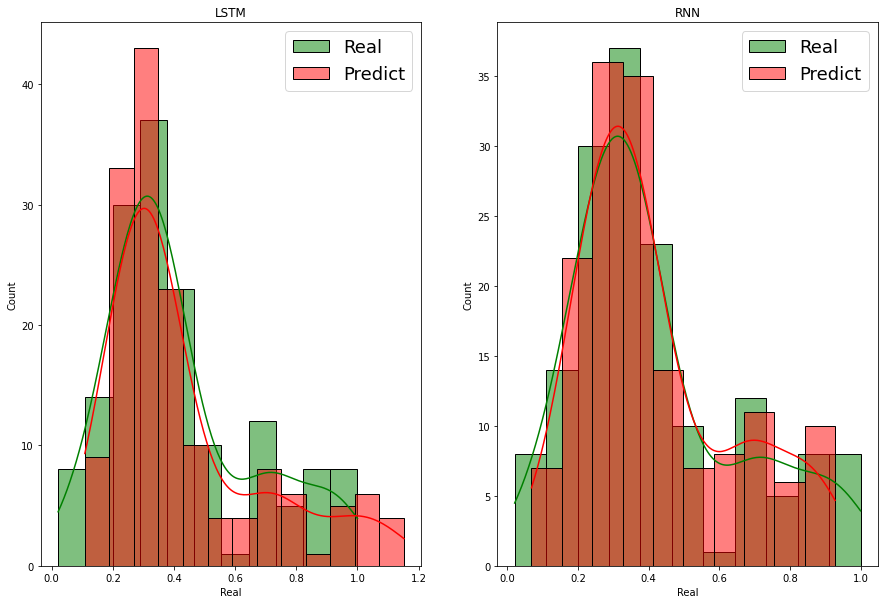

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

sns.histplot(data = df_plot_lstm, x ='Real', label = 'Real',kde = True, ax = ax[0],color = 'green')
sns.histplot(data = df_plot_lstm, x ='Predict', kde = True, label = 'Predict', ax = ax[0],color = 'red')

sns.histplot(data = df_plot_RNN, x ='Real', kde = True, label = 'Real', ax = ax[1],color = 'green')
sns.histplot(data = df_plot_RNN, x ='Predict', kde = True, label = 'Predict', ax = ax[1],color = 'red')

ax[0].set_title('LSTM')
ax[1].set_title('RNN')

ax[0].legend(fontsize=18)
ax[1].legend(fontsize=18)

plt.show()

##### Distribucion de Datos Reales vs Predecidos en Dispersion

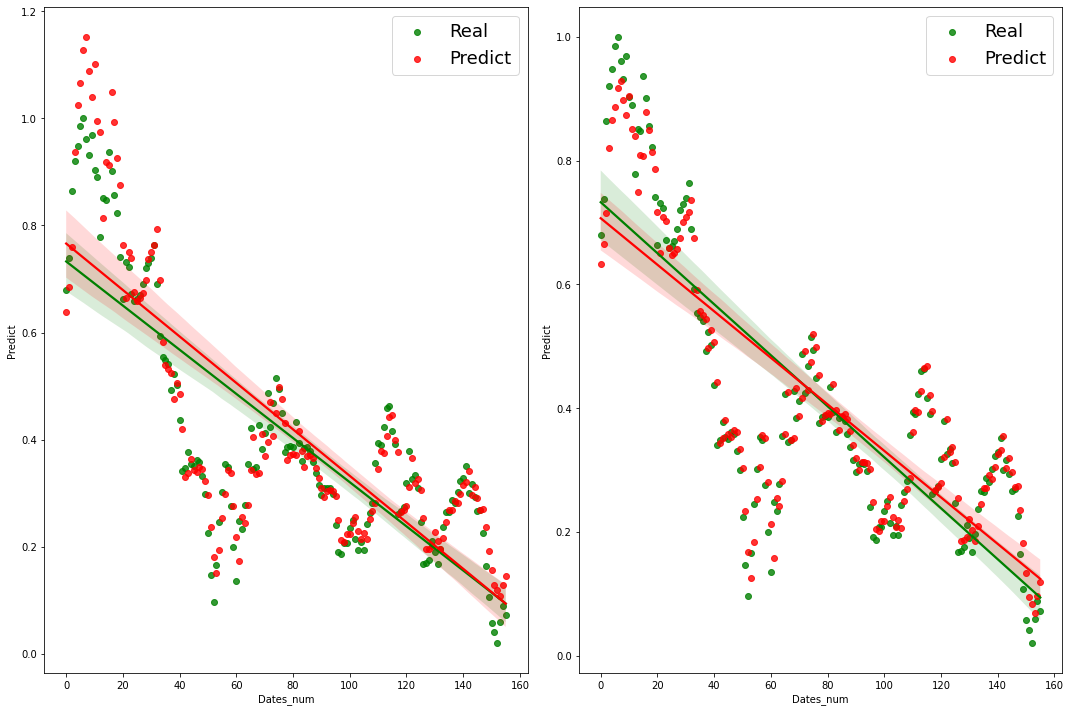

In [74]:
# Convertir fechas a valores numéricos
df_plot_lstm['Dates_num'] = range(len(df_plot_lstm))
df_plot_RNN['Dates_num'] = range(len(df_plot_RNN))

fig, axes = plt.subplots(1, 2, figsize=(15, 10))

sns.regplot(x='Dates_num', y='Real', data=df_plot_lstm, color='g', ax=axes[0], label='Real')
sns.regplot(x='Dates_num', y='Predict', data=df_plot_lstm, color='red', ax=axes[0], label='Predict')

sns.regplot(x='Dates_num', y='Real', data=df_plot_RNN, color='g', ax=axes[1], label='Real')
sns.regplot(x='Dates_num', y='Predict', data=df_plot_RNN, color='red', ax=axes[1], label='Predict')

axes[0].legend(fontsize=18)
axes[1].legend(fontsize=18)

plt.tight_layout()
plt.show()

###### Evaluacion de Metricas

In [77]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
def mean_percentage_error(y_true, y_pred):
    return np.mean((y_true - y_pred) / y_true) * 100

mse_LSTM = mean_squared_error(df_plot_lstm['Real'], df_plot_lstm['Predict'])
rmse_LSTM = np.sqrt(mse_LSTM)
r2_LSTM = r2_score(df_plot_lstm['Real'], df_plot_lstm['Predict'])
mae_LSTM = mean_absolute_error(df_plot_lstm['Real'], df_plot_lstm['Predict'])
mape_LSTM = mean_absolute_percentage_error(df_plot_lstm['Real'], df_plot_lstm['Predict'])
mpe_LSTM = mean_percentage_error(df_plot_lstm['Real'], df_plot_lstm['Predict'])

mse_RNN = mean_squared_error(df_plot_RNN['Real'], df_plot_RNN['Predict'])
rmse_RNN = np.sqrt(mse_RNN)
mae_RNN = mean_absolute_error(df_plot_RNN['Real'], df_plot_RNN['Predict'])
mape_RNN = mean_absolute_percentage_error(df_plot_RNN['Real'], df_plot_RNN['Predict'])
mpe_RNN = mean_percentage_error(df_plot_RNN['Real'], df_plot_RNN['Predict'])
r2_RNN = r2_score(df_plot_RNN['Real'], df_plot_RNN['Predict'])


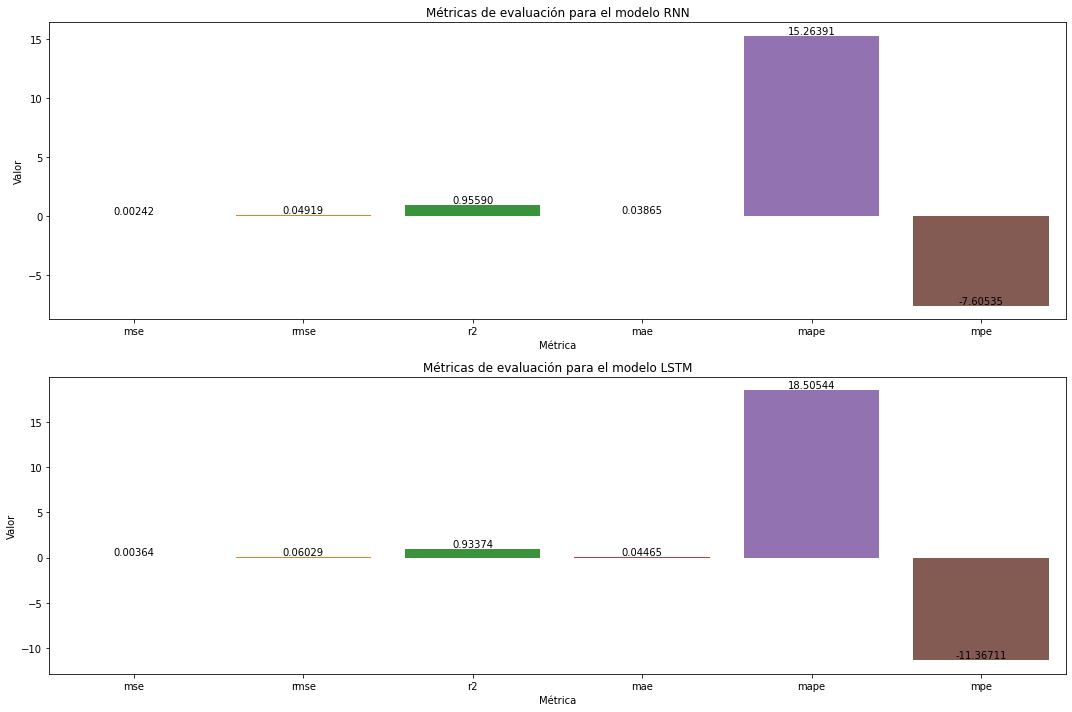

In [78]:
x=['mse', 'rmse', 'r2', 'mae', 'mape', 'mpe']
RNN = [mse_RNN, rmse_RNN, r2_RNN, mae_RNN, mape_RNN, mpe_RNN]
LSTM =[mse_LSTM,rmse_LSTM,r2_LSTM,mae_LSTM,mape_LSTM,mpe_LSTM]

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

sns.barplot(x=x, y=RNN, ax=axes[0])
axes[0].set_title('Métricas de evaluación para el modelo RNN')
axes[0].set_ylabel('Valor')
axes[0].set_xlabel('Métrica')

for index, value in enumerate(RNN):
    axes[0].text(index, value, '{:.5f}'.format(value), ha='center', va='bottom')
    
sns.barplot(x=x, y=LSTM, ax=axes[1])
axes[1].set_title('Métricas de evaluación para el modelo LSTM')
axes[1].set_ylabel('Valor')
axes[1].set_xlabel('Métrica')

for index, value in enumerate(LSTM):
    axes[1].text(index, value, '{:.5f}'.format(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

**END**